In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras import distribute
from tensorflow import keras
from tensorflow.keras import layers  # noqa
from tensorflow.keras.models import Sequential  # noqa
import os
import pathlib

plt.style.use('dark_background')

2023-06-13 14:26:28.406076: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos',origin=dataset_url, untar=True)

  5562368/228813984 [..............................] - ETA: 15:30

KeyboardInterrupt: 

In [ ]:
print(data_dir)

/root/.keras/datasets/flower_photos


In [ ]:
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


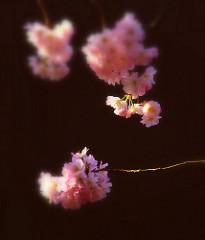

In [ ]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))
# на картинке с индексом 0 изображены не розы?

In [ ]:
batch_size = 32
img_height = 180 
img_width = 180

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


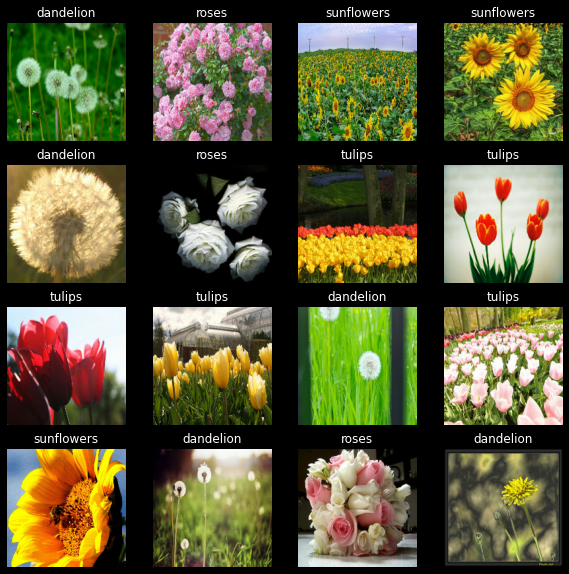

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break 

(32, 180, 180, 3)
(32,)


In [ ]:
# построение набора данных для оценки производительности
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# создание слоя нормализации данных
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# создание содели

num_classes = len(class_names)
model = Sequential([
    layers.Rescaling(1./255,   input_shape=(img_height,   img_width,3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    ])

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 64)       

In [ ]:
# обучение модели

epochs=10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/10
92/92 [==============================] - 106s 1s/step - loss: 1.4369 - accuracy: 0.4009 - val_loss: 1.1079 - val_accuracy: 0.5504
Epoch 2/10
92/92 [==============================] - 96s 1s/step - loss: 1.0584 - accuracy: 0.5814 - val_loss: 1.0606 - val_accuracy: 0.5640
Epoch 3/10
92/92 [==============================] - 96s 1s/step - loss: 0.9039 - accuracy: 0.6471 - val_loss: 0.9731 - val_accuracy: 0.6131
Epoch 4/10
92/92 [==============================] - 97s 1s/step - loss: 0.7033 - accuracy: 0.7428 - val_loss: 1.1370 - val_accuracy: 0.5845
Epoch 5/10
92/92 [==============================] - 97s 1s/step - loss: 0.5158 - accuracy: 0.8154 - val_loss: 1.0674 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 96s 1s/step - loss: 0.3259 - accuracy: 0.8968 - val_loss: 1.1885 - val_accuracy: 0.6199
Epoch 7/10
92/92 [==============================] - 98s 1s/step - loss: 0.2171 - accuracy: 0.9312 - val_loss: 1.6795 - val_accuracy: 0.5736
Epoch 8/10
92/92 [=

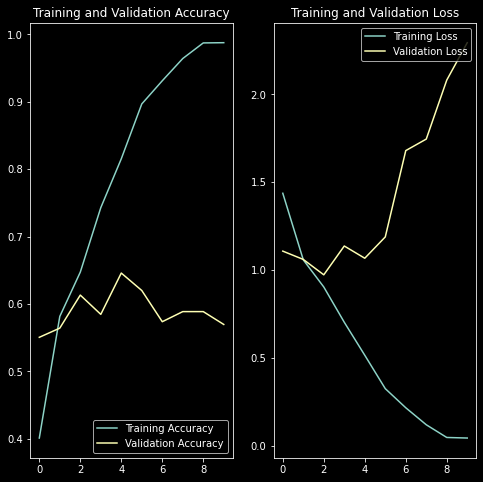

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [ ]:
# доработка модели - расширение данных

data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ])

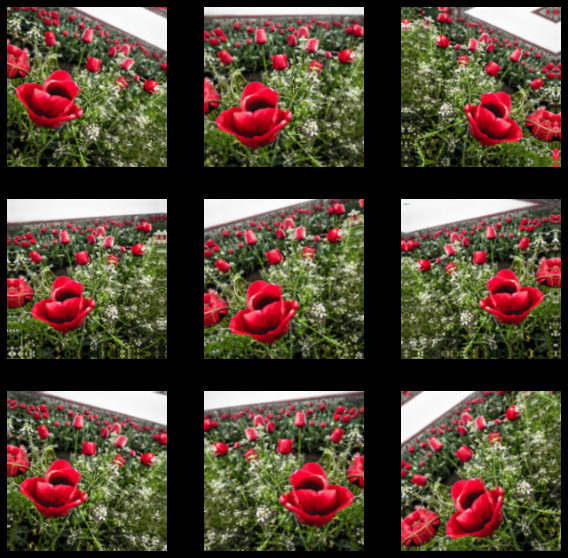

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
# доработка модели - отсев
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
    ])

In [ ]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy (from_logits=True), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                 

In [ ]:
# обучение
epochs = 15
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs)

Epoch 1/15
92/92 [==============================] - 115s 1s/step - loss: 1.3354 - accuracy: 0.4220 - val_loss: 1.1828 - val_accuracy: 0.4864
Epoch 2/15
92/92 [==============================] - 112s 1s/step - loss: 1.0365 - accuracy: 0.5886 - val_loss: 0.9588 - val_accuracy: 0.6199
Epoch 3/15
92/92 [==============================] - 112s 1s/step - loss: 0.9400 - accuracy: 0.6362 - val_loss: 0.9262 - val_accuracy: 0.6499
Epoch 4/15
92/92 [==============================] - 112s 1s/step - loss: 0.8704 - accuracy: 0.6570 - val_loss: 0.8913 - val_accuracy: 0.6526
Epoch 5/15
92/92 [==============================] - 110s 1s/step - loss: 0.8139 - accuracy: 0.6798 - val_loss: 0.8215 - val_accuracy: 0.6717
Epoch 6/15
92/92 [==============================] - 112s 1s/step - loss: 0.7638 - accuracy: 0.7061 - val_loss: 0.9047 - val_accuracy: 0.6717
Epoch 7/15
92/92 [==============================] - 111s 1s/step - loss: 0.7221 - accuracy: 0.7313 - val_loss: 0.7648 - val_accuracy: 0.7112
Epoch 8/15
92

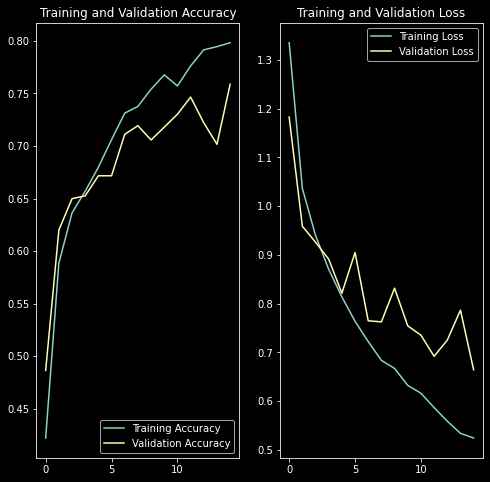

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path   =   tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)


img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 154ms/step
This image most likely belongs to sunflowers with a 99.13 percent confidence.


In [ ]:
sunflower_path   =   '/content/pink_roses.jpg'


img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 108ms/step
This image most likely belongs to roses with a 98.44 percent confidence.


In [ ]:
sunflower_path   =   '/content/rainbow_roses.jpg'


img = tf.keras.utils.load_img(sunflower_path, target_size=(img_height, img_width))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 32ms/step
This image most likely belongs to tulips with a 99.94 percent confidence.
